In [1]:
import pickle
import numpy as np
import os
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from tensorflow.keras.models import Model
import tensorflow as tf

In [2]:
tf.__version__

'2.12.0'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip
!unzip -qq Flickr8k_Dataset.zip
!unzip -qq Flickr8k_text.zip
!rm Flickr8k_Dataset.zip Flickr8k_text.zip

In [6]:
WORK_DIR = '/content/drive/MyDrive/CS762/image_captionning2-20221221T075329Z-001/image_captionning2'
BASE_DIR = './'

In [7]:
#load Model
model = VGG16()

# change Archi
model = Model(model.input, model.layers[-2].output)

model.summary()

553467096/553467096 [==============================] - 2s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [8]:
# #extract Features from image
# features ={}
# directory = os.path.join(BASE_DIR, 'Flicker8k_Dataset')

# for img_name in tqdm(os.listdir(directory)):
#     # load the image from file
#     img_path = directory + '/' + img_name
#     image = load_img(img_path, target_size=(224, 224))
#     # convert image pixels to numpy array
#     image = img_to_array(image)
#     # reshape data for model
#     image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
#     # preprocess image for vgg
#     image = preprocess_input(image)
#     # extract features
#     feature = model.predict(image, verbose=0)
#     # get image ID
#     image_id = img_name.split('.')[0]
#     # store feature
#     features[image_id] = feature

In [9]:
# load features form pickle
with open(os.path.join(WORK_DIR, 'features.pkl'), "rb") as f:
  features = pickle.load(f)

# Captoions

In [10]:
with open(os.path.join(BASE_DIR, 'Flickr8k.token.txt')) as f:
  captions_doc = f.read()

In [11]:
## Mapping 

mapping = {}

for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split('\t')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('#')[0].split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/40461 [00:00<?, ?it/s]

In [12]:
mapping.pop('2258277193_586949ec62')

['people waiting for the subway',
 'Some people looking out windows in a large building .',
 'Three people are waiting on a train platform .',
 'Three people standing at a station .',
 'two woman and one man standing near train tracks .']

In [13]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc., 
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [14]:
clean(mapping)

In [15]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [16]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [17]:
vocab_size

8485

In [18]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

34

In [19]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [20]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0



In [21]:
os.chdir(WORK_DIR)
from Transformer import Decoder


(None, 34, 8485)


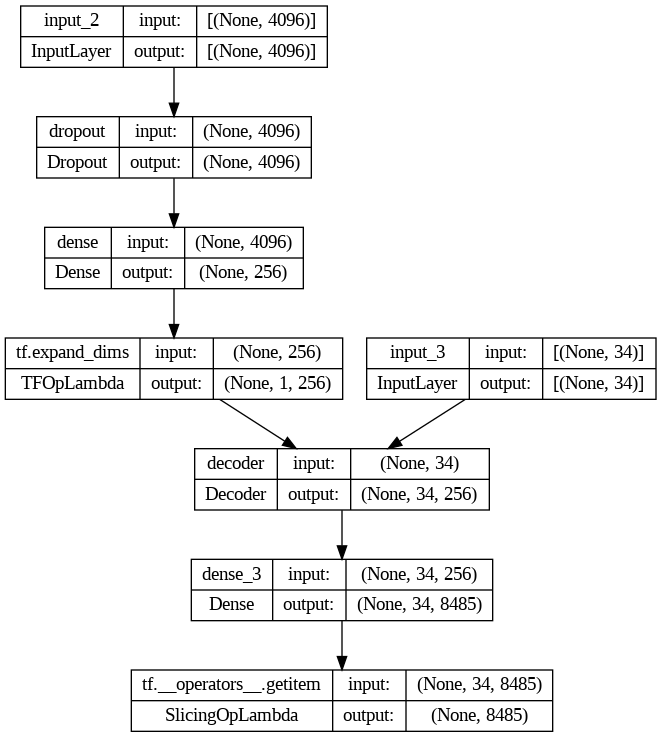

In [22]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

fe2 = tf.expand_dims(fe2, axis=1)
# sequence feature layers
sample_decoder = Decoder(num_layers=1,
                         d_model=256,
                         num_heads=4,
                         dff=2048,
                         vocab_size=8485)
inputs2 = Input(shape=(max_length,))
# se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
# se2 = Dropout(0.4)(se1)
# se3 = LSTM(256)(se2)
decoder = sample_decoder(
    x=inputs2,
    context=fe2)

# decoder model
# decoder1 = add([fe2, se3])
# decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder)
print(outputs.shape)

model = Model(inputs=[inputs1, inputs2], outputs=outputs[:,-1,:])
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

In [23]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 4096)]       0           []                               
                                                                                                  
 dropout (Dropout)              (None, 4096)         0           ['input_2[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 256)          1048832     ['dropout[0][0]']                
                                                                                                  
 input_3 (InputLayer)           [(None, 34)]         0           []                               
                                                                                            

In [24]:
model.load_weights(WORK_DIR+'/Transormermodel1.h5')

In [25]:
# train the model
epochs = 20
batch_size = 16
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    if i%2==0:
      model.save(WORK_DIR+'/Transormermodel1.h5')
      print('model weights saved')


455/455 [==============================] - 180s 371ms/step - loss: 1.6853
model weights saved
455/455 [==============================] - 161s 354ms/step - loss: 1.6375
model weights saved
455/455 [==============================] - 161s 354ms/step - loss: 1.6283
model weights saved
455/455 [==============================] - 161s 354ms/step - loss: 1.6209
model weights saved
455/455 [==============================] - 162s 355ms/step - loss: 1.6100
model weights saved
455/455 [==============================] - 162s 356ms/step - loss: 1.6062
model weights saved
455/455 [==============================] - 162s 355ms/step - loss: 1.5951
model weights saved
455/455 [==============================] - 161s 354ms/step - loss: 1.5883
model weights saved
455/455 [==============================] - 162s 355ms/step - loss: 1.5854
model weights saved
455/455 [==============================] - 162s 356ms/step - loss: 1.5771
model weights saved
455/455 [==============================] - 161s 355ms/step -

In [ ]:
model.save(WORK_DIR+'/Transormermodel1.h5')

In [26]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [27]:
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
      
    return in_text

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length) 
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

RuntimeError: ignored

In [28]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(directory, image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq soccer player in blue is chasing after the player in black and white endseq
startseq the girl in the white strip is falling down as the girl in the blue strip challenges for the soccer ball endseq
startseq the girls are playing soccer endseq
startseq two women in soccer uniforms playing soccer endseq
startseq two young women on different teams are playing soccer on field endseq
--------------------Predicted--------------------
startseq two men play field hockey endseq


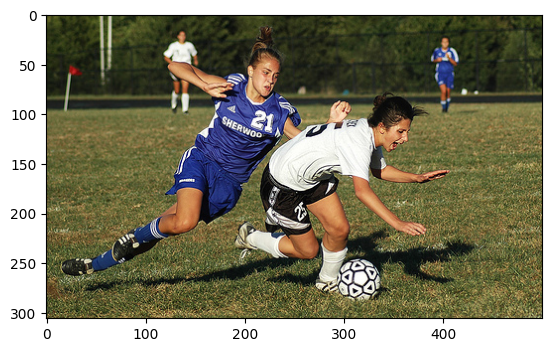

In [30]:
# directory = os.path.join(BASE_DIR, 'Flicker8k_Dataset')
directory = '/content/Flicker8k_Dataset'
generate_caption("47871819_db55ac4699.jpg")